In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

import torch
import torch.nn as nn
import numpy as np 

import random

import tqdm
import matplotlib.pyplot as plt
import sklearn.cluster

In [2]:
@nb.jit(nb.int32[:,:](
    nb.float32[:,:],nb.float32[:],nb.int32[:],nb.int32,nb.int32
),nopython=True)
def adjust_quantizations(weights:np.ndarray[np.float32],
                         quantization_values:np.ndarray[np.float32],
                         huffman_codes_nbits:np.ndarray[np.int32],
                         block_size:int = 64,
                         target_average_bits_per_weight:int = 2)->np.ndarray[np.int32]:
    """Adjust quantizations of weights to match the quantization values and huffman codes.

    Args:
        weights (np.ndarray[np.float32]): the weights, shape (n,m)
        original_quantizations (np.ndarray[np.int32]): the original quantized weights, shape (n,m)
        quantization_values (np.ndarray[np.float32]): the quantized weights, shape (n_quantizations,)
        huffman_codes_nbits (np.ndarray[np.int32]): the number of bits of each huffman code, shape (n_quantizations,)
        block_size (int, optional): the block size. Defaults to 64.
        target_average_bits_per_weight (int, optional): the target average bits per weight. Defaults to 2.
    """

    n,m = weights.shape

    quantizations = np.zeros((n,m),dtype=np.int32)
    #the blocks are along the second dimension so 

    for i in range(n):
        # if i%100 == 0:
        #     print(i)
        for j in range(0,m,block_size):
            block = weights[i,j:j+block_size]
            block_quantization = np.zeros(block_size,dtype=np.int32)
            current_n_bits_per_value = np.ones(block_size)
            nbits = 0

            #calculate the number of bits the current quantization uses
            for k in range(block_size):
                best_quantization_error = np.inf
                for q in range(len(quantization_values)):
                    error = abs(quantization_values[q] - block[k])
                    if error < best_quantization_error:
                        best_quantization_error = error
                        block_quantization[k] = q
                        current_n_bits_per_value[k] = huffman_codes_nbits[q]
                nbits += current_n_bits_per_value[k]
            # print(nbits)
            while nbits > target_average_bits_per_weight*block_size:
                #find the quantization that would reduce the number of bits the most
                minimal_change = np.inf

                location = -1
                new_quantization = -1
                # print("n_bits",nbits)
                for k in range(block_size):
                    for q in range(len(quantization_values)):
                        change_in_bits = huffman_codes_nbits[q] - huffman_codes_nbits[block_quantization[k]]
                        if change_in_bits < 0:
                            change = abs(quantization_values[q] - block[k])
                            if change < minimal_change:
                                minimal_change = change
                                change_bits = change_in_bits
                                location = k
                                new_quantization = q

                #apply the change
                block_quantization[location] = new_quantization
                nbits += change_bits

            quantizations[i,j:j+block_size] = block_quantization
            # print("breaking")
            # raise ValueError("break")
    return quantizations


            

In [3]:
device = torch.device("cuda:5")

H = torch.load("test/original_weights.pt")["H"].to(device).float()
weights = torch.load("test/original_weights.pt")["weights"].to(device).float()  

In [4]:
class huff_node:
    def __init__(self, value, count):
        self.value = value
        self.count = count
        self.left = None
        self.right = None
        self.code = ""

def huffman_code_recursive(nodes:list[huff_node]):
    if len(nodes) == 1:
        
        return nodes[0]
    nodes = sorted(nodes, key = lambda x: x.count)
    new_node = huff_node(None, nodes[0].count + nodes[1].count)
    new_node.left = nodes[0]
    new_node.right = nodes[1]
    return huffman_code_recursive([new_node] + nodes[2:])

def huffman_code_generate(node:huff_node):
    if node.left is not None:
        node.left.code = node.code + "0"
        huffman_code_generate(node.left)
    if node.right is not None:
        node.right.code = node.code + "1"
        huffman_code_generate(node.right)

def huffman_code(values,counts):
    nodes = [huff_node(value, count) for value, count in zip(values,counts)]
    root = huffman_code_recursive(nodes)
    huffman_code_generate(root)
    return {node.value: node.code for node in nodes}


In [5]:
weights_numpy = weights.cpu().numpy()

In [6]:
def optimize_quantizations(weights,quantizations, codebook, H,
                           n_iters = 1000, lr = 1e-3,
                           lr_multiplier = 0.99):
    #cast quantizations to torch array
    quantizations = torch.from_numpy(quantizations).to(weights.device)
    #cast codebook to torch array
    codebook = torch.from_numpy(codebook).to(weights.device).requires_grad_(True)
    
    prev_loss = np.inf
    for i in tqdm.tqdm(range(n_iters)):
        #calculate the loss
        quantized_weights = codebook[quantizations]
        diff = weights - quantized_weights


        H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)
        H_error.backward()
        # print(H_error)
        
        
        if H_error > prev_loss:
            # print("Loss increased, reducing learning rate")
            lr *= lr_multiplier
            
        prev_loss = H_error.item()
        
        with torch.no_grad():
            codebook -= torch.clamp(lr*codebook.grad,-1e-3,1e-3)
            codebook.grad = None
    print(H_error.item()) 
    return quantized_weights.detach().cpu().numpy(), codebook.detach().cpu().numpy()

In [7]:
def entropy(counts):
    e = 0
    
    for count in counts:
        if count == 0:
            continue
        e -= count*np.log2(count/np.sum(counts))
    return e/np.sum(counts)

In [8]:


n_quantizations = 64
print(np.log2(n_quantizations))
n_iters = 10

codebook = np.linspace(weights_numpy.min(),weights_numpy.max(),n_quantizations).astype(np.float32)

# codebook = np.sort(np.random.choice(weights_numpy.flatten(),n_quantizations,replace=False)).astype(np.float32)
# print(quantization_values)
counts = np.histogram(weights_numpy.flatten(), bins = list(codebook) + [np.inf])[0]

for i in range(n_iters):
    print(counts.shape)
    print(entropy(counts))
    # raise Exception("stop")
    huffman_codes = huffman_code(codebook,counts)
    print(len(huffman_codes))
    # raise Exception("stop")
    # for q in range(n_quantizations):
    #     print(codebook[q],len(huffman_codes[codebook[q]]))
    n_bits = np.array([len(huffman_codes[codebook[q]]) for q in range(n_quantizations)]).astype(np.int32)
    print(np.min(n_bits),np.max(n_bits))
    # raise Exception("stop")
    quantized_weights_indexs = adjust_quantizations(weights_numpy,codebook,n_bits,
                                                block_size=256,target_average_bits_per_weight=2)
    
    quantized_weights, codebook = optimize_quantizations(weights,quantized_weights_indexs,codebook,H,
                                                            n_iters = 100, lr = 1e-2,
                                                            lr_multiplier = 0.9)
    raise Exception("stop")
    counts = np.zeros_like(counts)
    for i in range(n_quantizations):
        counts[i] = (quantized_weights_indexs == i).sum()



6.0
(64,)
2.2778780099101126
64
1 25


100%|██████████| 100/100 [02:42<00:00,  1.63s/it]


41.08998107910156


Exception: stop

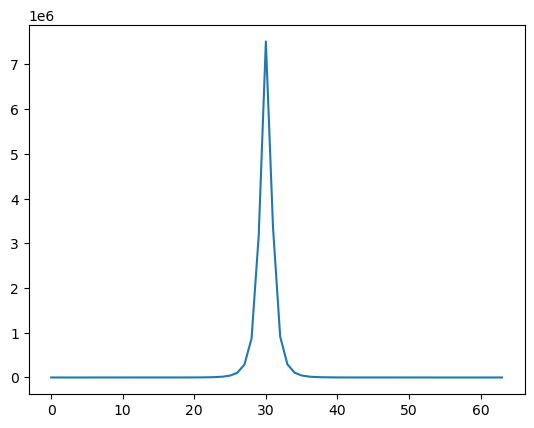

In [9]:
plt.plot(counts)

In [10]:
quantized_weights

array([[-0.04693748, -0.04693748, -0.04693748, ..., -0.04693748,
        -0.04693748, -0.04693748],
       [-0.04693748, -0.04693748, -0.04693748, ..., -0.04693748,
        -0.04693748, -0.04693748],
       [-0.04693748, -0.04693748, -0.04693748, ..., -0.04693748,
        -0.04693748, -0.04693748],
       ...,
       [-0.04693748, -0.04693748,  0.11278902, ..., -0.04693748,
        -0.04693748, -0.04693748],
       [-0.04693748, -0.04693748, -0.04693748, ..., -0.04693748,
        -0.04693748, -0.04693748],
       [-0.04693748, -0.04693748, -0.04693748, ...,  0.11278902,
        -0.04693748, -0.04693748]], dtype=float32)

In [23]:
np.max(np.sum(n_bits[quantized_weights_indexs].reshape(quantized_weights.shape[0],-1,256),axis=2))/256

1.93359375

In [25]:
lr = 1e-3
lr_multiplier = 0.9

#cast quantizations to torch array
quantizations = torch.from_numpy(quantized_weights_indexs).to(weights.device)
#cast codebook to torch array
codebook = torch.from_numpy(codebook).to(weights.device).requires_grad_(True)

prev_loss = np.inf
for i in range(n_iters):
    #calculate the loss
    quantized_weights = codebook[quantizations]
    diff = weights - quantized_weights


    H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)
    H_error.backward()
    print(H_error)
    
    if H_error > prev_loss:
        lr *= lr_multiplier
    
    prev_loss = H_error
    with torch.no_grad():
        codebook -= lr*codebook.grad
        codebook.grad.zero_()
        
# return quantized_weights, codebook

tensor(inf, device='cuda:5', grad_fn=<ViewBackward0>)
tensor(nan, device='cuda:5', grad_fn=<ViewBackward0>)
tensor(nan, device='cuda:5', grad_fn=<ViewBackward0>)
tensor(nan, device='cuda:5', grad_fn=<ViewBackward0>)
tensor(nan, device='cuda:5', grad_fn=<ViewBackward0>)
tensor(nan, device='cuda:5', grad_fn=<ViewBackward0>)
tensor(nan, device='cuda:5', grad_fn=<ViewBackward0>)
tensor(nan, device='cuda:5', grad_fn=<ViewBackward0>)
tensor(nan, device='cuda:5', grad_fn=<ViewBackward0>)
tensor(nan, device='cuda:5', grad_fn=<ViewBackward0>)


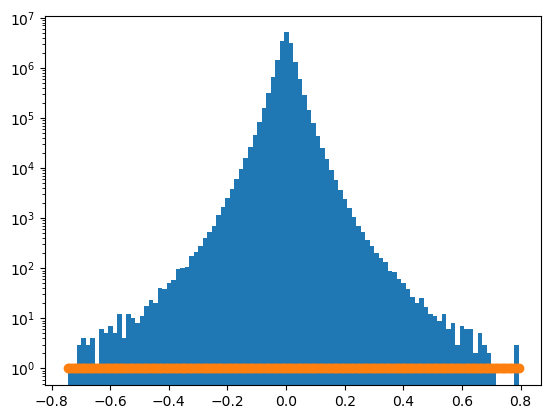

In [16]:
plt.hist(weights.flatten(),bins=100)
plt.plot(quantization_values,np.ones_like(quantization_values),"o")
plt.yscale("log")

In [12]:
quantization_values

array([-0.74511719, -0.73908548, -0.73305377, -0.72702206, -0.72099035,
       -0.71495864, -0.70892693, -0.70289522, -0.69686351, -0.6908318 ,
       -0.68480009, -0.67876838, -0.67273667, -0.66670496, -0.66067325,
       -0.65464154, -0.64860983, -0.64257812, -0.63654642, -0.63051471,
       -0.624483  , -0.61845129, -0.61241958, -0.60638787, -0.60035616,
       -0.59432445, -0.58829274, -0.58226103, -0.57622932, -0.57019761,
       -0.5641659 , -0.55813419, -0.55210248, -0.54607077, -0.54003906,
       -0.53400735, -0.52797564, -0.52194393, -0.51591222, -0.50988051,
       -0.50384881, -0.4978171 , -0.49178539, -0.48575368, -0.47972197,
       -0.47369026, -0.46765855, -0.46162684, -0.45559513, -0.44956342,
       -0.44353171, -0.4375    , -0.43146829, -0.42543658, -0.41940487,
       -0.41337316, -0.40734145, -0.40130974, -0.39527803, -0.38924632,
       -0.38321461, -0.3771829 , -0.37115119, -0.36511949, -0.35908778,
       -0.35305607, -0.34702436, -0.34099265, -0.33496094, -0.32